# Image Classification with Deep Learning using Keras

Based on Keras tutorial by @fchollet at: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Deep Learning using very little data.

Dataset (Cats and Dogs) from Kaggle at: https://www.kaggle.com/c/dogs-vs-cats/data

### Key approach

* train a small network from scratch (as baseline)
* using the bottleneck features of a pre-trained network (VGG)
* fine-tuning the top layers of a pre trained network

Main limitations:
* We are deliberately limiting the Training dataset to 1000 images per class (=2000 total) for cats / dogs)
* We use 400 images each class for Validation


In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs
So that we have 1000 training examples for each class, and 400 validation examples for each class.


### Data Augmentation using Keras

Use Keras to augment data -- by performing a set of random transformations -- so that the network can train better. We will use `keras.preprocessing.image.ImageDataGenerator` for data augmentation. 


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

%matplotlib inline 

In [3]:
%load_ext watermark 
%watermark -a 'Atul Acharya' -u -d -v -p numpy,tensorflow,matplotlib,keras

Atul Acharya 
last updated: 2016-12-05 

CPython 3.5.2
IPython 5.0.0

numpy 1.11.2
tensorflow 0.11.0rc2
matplotlib 1.5.1
keras 1.1.0


Let's try data augmentation straight away


In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [4]:


datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')
x = img_to_array(img)   # this is numpy array with (Height x Width x Channels)
print(x.shape)
x = x.reshape((1,) + x.shape)
print("X.reshape:", x.shape)   # (1, Height, Width, Channels)

# use .flow() command to generat some images
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview',
                         save_prefix='cat',
                         save_format='jpeg'):
    i += 1
    if i > 20:
        break   # else endless loop


(374, 500, 3)
X.reshape: (1, 374, 500, 3)


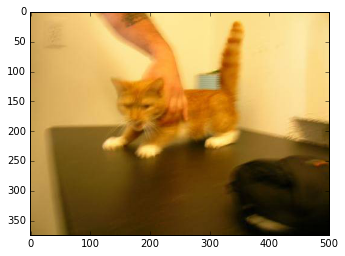

In [5]:
# show the image
from IPython.display import Image
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(img)


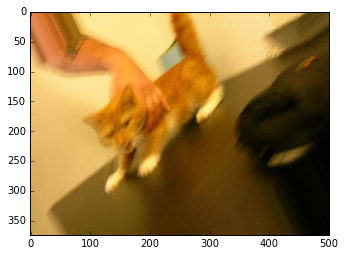

In [6]:
# transformed image
imshow(load_img('preview/cat_0_2563.jpeg'))  # one of the transformed images

## Baseline model -- Train a small CNN 

Use transformations to train a small CNN for 80% accuracy

In [5]:
# dimensions of our images.
IMG_WIDTH, IMG_HEIGHT = 150, 150

TRAIN_DATA_DIR = 'data/train'
VALIDATION_DATA_DIR = 'data/validation'
NB_TRAIN_SAMPLES = 2000
NB_VALIDATION_SAMPLES = 800
NB_EPOCH = 10

In [6]:
K.image_dim_ordering()

'tf'

In [7]:
#### NOTE: KLUDGE to get the example working!!
K.set_image_dim_ordering('th') ## Set to Theano image dim ordering..
# verify
K.image_dim_ordering()

'th'

In [8]:
### NOTE: Another KLUDGE
import tensorflow as tf
tf.python.control_flow_ops = tf

In [12]:
## Baseline model

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

baseline_model = Sequential()
# Layer 1
baseline_model.add(Convolution2D(32, 3, 3, input_shape=(3, IMG_WIDTH, IMG_HEIGHT)))
baseline_model.add(Activation('relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# Layer 2
baseline_model.add(Convolution2D(32, 3, 3))
baseline_model.add(Activation('relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# Layer 3
baseline_model.add(Convolution2D(64, 3, 3))
baseline_model.add(Activation('relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten - convert 3D features to 1D vectors
baseline_model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors
baseline_model.add(Dense(64))
baseline_model.add(Activation('relu'))
# Dropout
baseline_model.add(Dropout(0.5))
baseline_model.add(Dense(1))
baseline_model.add(Activation('sigmoid'))

baseline_model.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 32, 148, 148)  896         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 32, 148, 148)  0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 32, 74, 74)    0           activation_8[0][0]               
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 32, 72, 72)    9248        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [13]:
## Compile the model
baseline_model.compile(loss='binary_crossentropy',  # since TWO classe: Dogs / Cats
                      optimizer='rmsprop',
                      metrics=['accuracy'])

### implement Image data augmentation


In [14]:
# for Training
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# for Testing -- only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Read pics in subfolders of 'data/train', and infinitely generate augmented images
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=32,
                                                   class_mode='binary')

validation_generator = test_datagen.flow_from_directory(VALIDATION_DATA_DIR,
                                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                       batch_size=32,
                                                       class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


In [18]:
## Train the model!
history = baseline_model.fit_generator(train_generator,
                                      samples_per_epoch=NB_TRAIN_SAMPLES,
                                      nb_epoch=NB_EPOCH,   # Just 10 epochs for now
                                      validation_data=validation_generator,
                                      nb_val_samples=NB_VALIDATION_SAMPLES)

#baseline_model.load_weights('baseline_model.h5')

Epoch 1/10
2000/2000 [==============================] - 186s - loss: 0.5675 - acc: 0.7035 - val_loss: 0.5244 - val_acc: 0.7566
Epoch 2/10
2000/2000 [==============================] - 184s - loss: 0.5713 - acc: 0.7090 - val_loss: 0.6835 - val_acc: 0.6604
Epoch 3/10
2000/2000 [==============================] - 190s - loss: 0.5554 - acc: 0.7225 - val_loss: 0.7001 - val_acc: 0.6792
Epoch 4/10
2000/2000 [==============================] - 177s - loss: 0.5324 - acc: 0.7280 - val_loss: 0.5405 - val_acc: 0.7104
Epoch 5/10
2000/2000 [==============================] - 181s - loss: 0.5131 - acc: 0.7470 - val_loss: 0.5568 - val_acc: 0.7079
Epoch 6/10
2000/2000 [==============================] - 187s - loss: 0.5115 - acc: 0.7530 - val_loss: 0.5100 - val_acc: 0.7391
Epoch 7/10
2000/2000 [==============================] - 177s - loss: 0.4935 - acc: 0.7575 - val_loss: 0.5131 - val_acc: 0.7491
Epoch 8/10
2000/2000 [==============================] - 175s - loss: 0.4691 - acc: 0.7725 - val_loss: 0.4934 - 

OSError: Unable to open file (Unable to open file: name = 'baseline_model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [19]:
# save model
from keras.models import load_model
baseline_model.save('baseline_10epochs.h5')

In [20]:
history.history.keys()

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])

### Plotting History



In [35]:
def plot_accuracy(history, model_name='model', y1='acc', y2='val_acc'):
    ''' Plot Accuracy 
    '''
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' accuracy' )
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

In [36]:
def plot_loss(history, model_name='model', y1='loss', y2='val_loss'):
    ''' Plot Loss 
    '''
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' loss' )
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

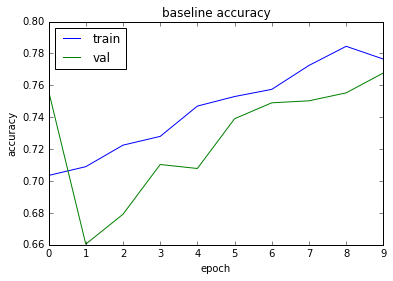

In [24]:
%matplotlib inline
plot_accuracy(history, model_name='baseline')

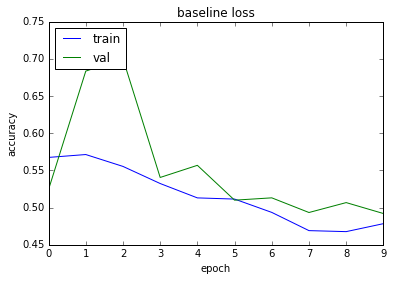

In [25]:
plot_loss(history, model_name='baseline')

# Using pre-trained VGG16 model for classification

Here we use the pretrained VGG16 model used for ImageNet, and use its CNN blocks only, to predict our Catgs vs Dogs. 

As noted in the blog post: 

```
Using the bottleneck features of a pre-trained network: 90% accuracy in a minute

A more refined approach would be to leverage a network pre-trained on a large dataset. Such a network would have already learned features that are useful for most computer vision problems, and leveraging such features would allow us to reach a better accuracy than any method that would only rely on the available data.

We will use the VGG16 architecture, pre-trained on the ImageNet dataset --a model previously featured on this blog. Because the ImageNet dataset contains several "cat" classes (persian cat, siamese cat...) and many "dog" classes among its total of 1000 classes, this model will already have learned features that are relevant to our classification problem. In fact, it is possible that merely recording the softmax predictions of the model over our data rather than the bottleneck features would be enough to solve our dogs vs. cats classification problem extremely well. However, the method we present here is more likely to generalize well to a broader range of problems, including problems featuring classes absent from ImageNet.
```

Our strategy will be as follow: we will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

The reason why we are storing the features offline rather than adding our fully-connected model directly on top of a frozen convolutional base and running the whole thing, is computational effiency. Running VGG16 is expensive, especially if you're working on CPU, and we want to only do it once. Note that this prevents us from using data augmentation.

You can find the full code for this experiment here [https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069]. You can get the weights file from Github. [https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3] We won't review how the model is built and loaded --this is covered in multiple Keras examples already. But let's take a look at how we record the bottleneck features using image data generators:

In [9]:
VGG16_WEIGHTS_PATH = 'vgg16_weights.h5'

TOP_MODEL_WEIGHTS = 'bottleneck_fc_weights.h5'

In [14]:
## Save the bottleneck features

from keras.layers import ZeroPadding2D

def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    print('Creating VGG16 model..')
    
    # Build the VGG16 network -- upto the CNN blocks
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, IMG_WIDTH, IMG_HEIGHT)))
    
    # CNN Block - 1
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # CNN Block - 2
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # CNN Block - 3
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # CNN Block - 4
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # CNN Block - 5
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # load the weights of the VGG16 networks
    # (trained on ImageNet, won the ILSVRC competition in 2014)
    # note: when there is a complete match between your model definition
    # and your weight savefile, you can simply call model.load_weights(filename)
    assert os.path.exists(VGG16_WEIGHTS_PATH), 'Model weights not found (see "WEIGHTS_PATH" variable in script).'
    
    f = h5py.File(VGG16_WEIGHTS_PATH)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # dont look at the last (FC) layers
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        # set the weights (from model file) to our network
        model.layers[k].set_weights(weights)
    f.close()
    print('VGG16 model loaded')
    
    ## Train data generator
    generator = datagen.flow_from_directory(TRAIN_DATA_DIR,
                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                           batch_size=32,
                                           class_mode=None, # this means our generator will only yield batches of data, no labels
                                           shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
    
    ## 
    print('Getting TRAIN features bottleneck..')
    # the predict_generator method returns the output of a model, given
    # a generator that yields batches of numpy data
    bottleneck_features_train = model.predict_generator(generator, 2000)
    # save the output as a Numpy array
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    ## Test/Validation generator
    generator = datagen.flow_from_directory(VALIDATION_DATA_DIR,
                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                           batch_size=32,
                                           class_mode=None, # this means our generator will only yield batches of data, no labels
                                           shuffle=False) # our data will be in order
    
    print('Getting VALIDATION features bottleneck..')

    bottleneck_features_validation = model.predict_generator(generator, 800)
    # Save validation output
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)


In [33]:
## NOw train our model
def train_top_model():
    # get the bottleneck features
    train_data   = np.load(open('bottleneck_features_train.npy', 'rb'))
    # two classes only
    train_labels = np.array([0] * (NB_TRAIN_SAMPLES // 2) + [1] * (NB_TRAIN_SAMPLES // 2))

    validation_data   = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * (NB_VALIDATION_SAMPLES // 2) + [1] * (NB_VALIDATION_SAMPLES // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile our model
    model.compile(optimizer='rmsprop', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Train/fit the model
    print('Fitting the model....')
    vgg_history = model.fit(train_data, 
              train_labels,
              nb_epoch=50,    # 50 epochs 
              batch_size=32,
              validation_data=(validation_data, validation_labels))
    # Save OUR trained model
    model.save_weights(TOP_MODEL_WEIGHTS)
    
    return vgg_history

In [16]:
## Now run the functions
save_bottleneck_features()

Creating VGG16 model..
VGG16 model loaded
Found 2000 images belonging to 2 classes.
Getting TRAIN features bottleneck..
Found 801 images belonging to 2 classes.
Getting VALIDATION features bottleneck..


In [17]:
# Now run the model to predict
train_top_model()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte

In [19]:
# Some numpy / unicode error. let's try again
x_train = np.load(open('bottleneck_features_train.npy', 'rb'))

In [20]:
print(x_train.shape)

(2000, 512, 4, 4)


In [22]:
x_valid = np.load(open('bottleneck_features_validation.npy', 'rb'))
print(x_valid.shape)

del x_train
del x_valid

(800, 512, 4, 4)


In [32]:
# lets try again
train_top_model()

Fitting the model....
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s - loss: 0.8845 - acc: 0.6795 - val_loss: 0.6928 - val_acc: 0.5650
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 0.4456 - acc: 0.8005 - val_loss: 0.5123 - val_acc: 0.7750
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 0.3951 - acc: 0.8185 - val_loss: 0.4762 - val_acc: 0.7562
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.3460 - acc: 0.8580 - val_loss: 0.3250 - val_acc: 0.8562
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.2957 - acc: 0.8735 - val_loss: 0.3217 - val_acc: 0.8712
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.2683 - acc: 0.8880 - val_loss: 0.3249 - val_acc: 0.8688
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.2373 - acc: 0.8940 - val_loss: 0.5729 - val_acc: 0.7863
Epoch 8/50
2000/2000 [==============================] - 

In [34]:
# Let's run the VGG model again -- and plot history
vgg_hist = train_top_model()

Fitting the model....
Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s - loss: 1.0249 - acc: 0.6705 - val_loss: 0.5118 - val_acc: 0.7300
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 0.4454 - acc: 0.7980 - val_loss: 0.3321 - val_acc: 0.8600
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 0.3622 - acc: 0.8395 - val_loss: 0.3459 - val_acc: 0.8438
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.3591 - acc: 0.8525 - val_loss: 0.3247 - val_acc: 0.8700
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.2897 - acc: 0.8725 - val_loss: 0.3145 - val_acc: 0.8725
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.2700 - acc: 0.8880 - val_loss: 0.5823 - val_acc: 0.8037
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.2395 - acc: 0.9050 - val_loss: 0.8276 - val_acc: 0.7550
Epoch 8/50
2000/2000 [==============================] - 

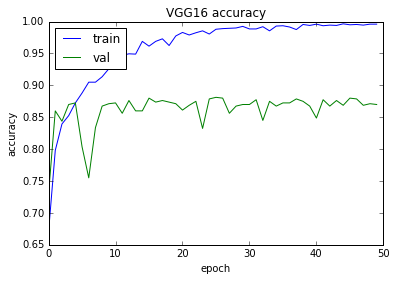

In [37]:
# let's Plot 
plot_accuracy(vgg_hist, model_name='VGG16')

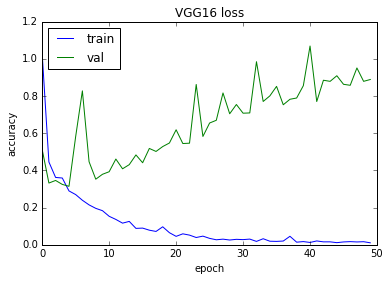

In [38]:
plot_loss(vgg_hist, model_name='VGG16')

### Results

We can see that the initial VGG16 model -- with FC layers replaced by ours -- reaches about 87% accuracy. And it does a bit of overfitting after epoch 10-12 or so. 

Can we do better than this?

# Fine-tune Top Layers of a Pre-trained Network

We can do better by fine tuning the top layers of a pretrained network, in this case, the VGG16. 

Here's note from the Keras blog:
```
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block

```

#### Note that:

in order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.

we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).

fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.


In [40]:
## Build the VGG16 model

VGG16_WEIGHTS_PATH = 'vgg16_weights.h5'    # downloaded from Github

TOP_MODEL_WEIGHTS = 'bottleneck_fc_weights.h5'    # one we trained above

# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, IMG_WIDTH, IMG_HEIGHT)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

print('Loading VGG model...')

# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
assert os.path.exists(VGG16_WEIGHTS_PATH), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(VGG16_WEIGHTS_PATH)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('VGG16 Model loaded.')

#### NOW, build a  Classifier on Top of the CNN VGG16
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
print('Loading Top Model: ', TOP_MODEL_WEIGHTS)
top_model.load_weights(TOP_MODEL_WEIGHTS)
print('Loaded Top Model: ', TOP_MODEL_WEIGHTS)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block) -- FROZEN LAYERS
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# print
model.summary()


Loading VGG model...
VGG16 Model loaded.
Loading Top Model:  bottleneck_fc_weights.h5
Loaded Top Model:  bottleneck_fc_weights.h5
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_27 (ZeroPadding2D) (None, 3, 152, 152)   0           zeropadding2d_input_3[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 150, 150)  0           zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 152, 152)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 150, 150)  0      

In [47]:
## Compile the model

from keras import optimizers

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


In [48]:
### NOW, do data augmentation

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=32,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


In [49]:
## NOW - Train / Fit the model

# fine-tune the model
vgg_finetuned_history = model.fit_generator(train_generator,
        samples_per_epoch=NB_TRAIN_SAMPLES,
        nb_epoch=NB_EPOCH,
        validation_data=validation_generator,
        nb_val_samples=NB_VALIDATION_SAMPLES)

Epoch 1/10
 512/2000 [======>.......................] - ETA: 750s - loss: 0.5951 - acc: 0.8535

KeyboardInterrupt: 